In [47]:
# import library
import numpy as np
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

import keras
import visualkeras
import graphviz
from keras.utils import plot_model
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from kerastuner import HyperParameters
import kerastuner as kt
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.models import Model


import warnings
warnings.filterwarnings('ignore')

In [17]:
#! pip install keras
#! pip install tensorflow
#! pip install visualkeras
#! pip install graphviz
#! pip install keras-tuner

# Load Data Subset based on Class Imbalance Analysis
*Data Source: [Fashion Product Images (Small)](https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small)*

In [2]:
! unzip Fashion.zip

Archive:  Fashion.zip
  inflating: images/10000.jpg        
  inflating: images/10001.jpg        
  inflating: images/10002.jpg        
  inflating: images/10003.jpg        
  inflating: images/10004.jpg        
  inflating: images/10005.jpg        
  inflating: images/10006.jpg        
  inflating: images/10007.jpg        
  inflating: images/10008.jpg        
  inflating: images/10009.jpg        
  inflating: images/10010.jpg        
  inflating: images/10011.jpg        
  inflating: images/10012.jpg        
  inflating: images/10013.jpg        
  inflating: images/10014.jpg        
  inflating: images/10015.jpg        
  inflating: images/10016.jpg        
  inflating: images/10017.jpg        
  inflating: images/10018.jpg        
  inflating: images/10019.jpg        
  inflating: images/10020.jpg        
  inflating: images/10021.jpg        
  inflating: images/10022.jpg        
  inflating: images/10023.jpg        
  inflating: images/10024.jpg        
  inflating: images/10025.jp

Text(0.5, 1.0, 'Class Distribution')

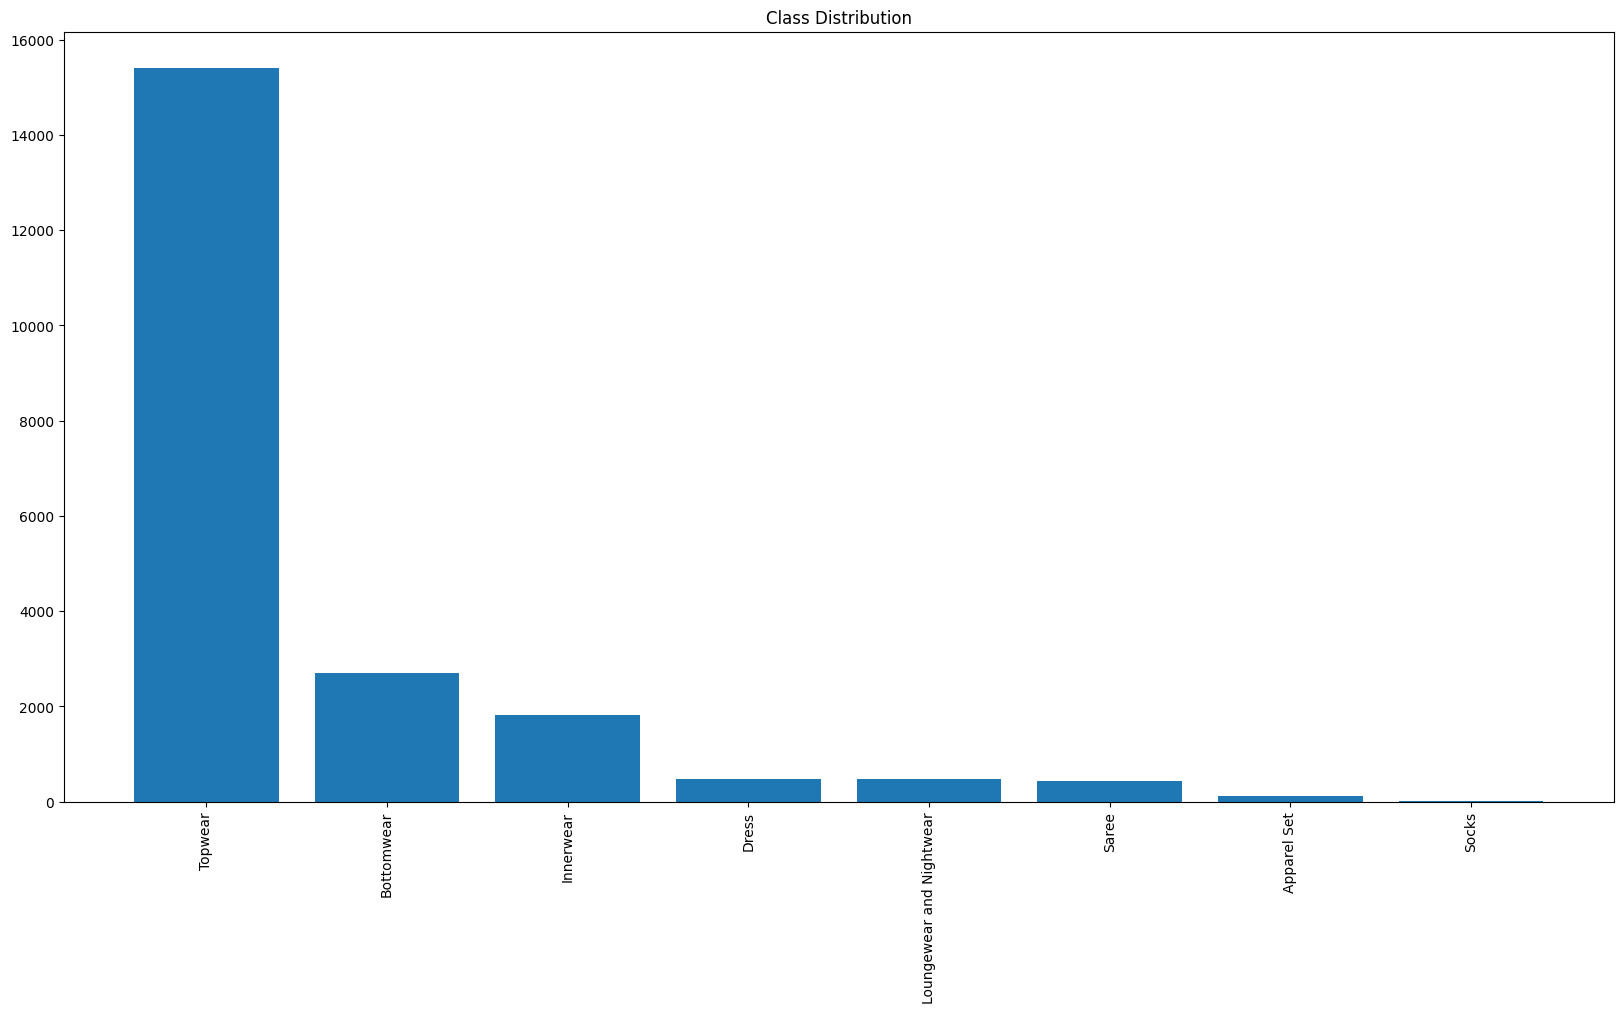

In [20]:
# Load label data
df_full = pd.read_csv('myntradataset/styles.csv', on_bad_lines='skip')
apparel_df = df_full[df_full['masterCategory'] == 'Apparel']

# plot class distribution
plt.figure(figsize=(20, 10))
plt.bar(apparel_df['subCategory'].value_counts().index, apparel_df['subCategory'].value_counts())
plt.xticks(rotation=90)
plt.title('Class Distribution')

In [21]:
# Subsample the data: pick 400 samples from each class
sub_df1 = apparel_df[~apparel_df.subCategory.isin(['Apparel Set', 'Socks'])]
sub_df2 = pd.DataFrame()
for i in sub_df1['subCategory'].unique():
    cat_df = apparel_df[apparel_df['subCategory'] == i].sample(400)
    sub_df2 = pd.concat([sub_df2, cat_df])
sub_df2['subCategory'].value_counts()

subCategory
Topwear                     400
Bottomwear                  400
Innerwear                   400
Saree                       400
Dress                       400
Loungewear and Nightwear    400
Name: count, dtype: int64

In [23]:
# Stratified train-test split
sub_df2 = sub_df2[['id','subCategory']]
sub_df2['img_path'] = sub_df2['id'].apply(lambda x: 'myntradataset/images/' + str(x) + '.jpg')
train_df, test_df = train_test_split(sub_df2, test_size=0.2, stratify=sub_df2["subCategory"], random_state=42)

In [24]:
# load in training and testing data according the to path
def preprocess_images(df, image_size = None):
    images = []
    labels = []
    for index, row in df.iterrows():
        path = row['img_path']
        label = row['subCategory']
        # Load the image
        image = Image.open(path)
        # Remove invalid data
        if np.array(image).shape != (80,60,3):
            continue
        # Resize the image
        if image_size != None:
            image = image.resize(image_size)
        # Convert the image to numpy array
        image = np.array(image)
        # Normalize the image
        image = image.astype('float32') / 255.0
        # Add the image and label to the lists
        images.append(image)
        labels.append(label)
    # Convert the lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

x_train, y_train = preprocess_images(train_df)
x_test, y_test = preprocess_images(test_df)
print("X_train shape: ", x_train.shape)
print("Y_train shape: ", y_train.shape)
print("X_test shape: ", x_test.shape)
print("Y_test shape: ", y_test.shape)

X_train shape:  (1909, 80, 60, 3)
Y_train shape:  (1909,)
X_test shape:  (478, 80, 60, 3)
Y_test shape:  (478,)


# EDA
### Visualize images


In [25]:
# visualize training images and and label
images_and_labels = list(zip(x_train, y_train))
plt.figure(figsize=(12, 6))
for index, (image, label) in enumerate(images_and_labels[:16]):
    plt.subplot(4,4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    index = np.where(label == 1)
    plt.title(label)
plt.show()

# Model Training and Evaluation

In [26]:
# Encode the labels
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [27]:
# Set up constants
num_classes = 6
input_shape = (80, 60, 3)

### Custom Model
#### Hyperparameter Tuning

In [28]:
# Define model architecture and the hyperparameter search space
def build_model(hp):
    model = keras.Sequential()
    
    # Tune the number of filters in the Conv2D layer
    #hp_filters = hp.Int('filters', min_value=32, max_value=128, step=32)
    model.add(layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))

    # Tune the pooling size
    hp_pooling = hp.Int('pooling', min_value=2, max_value=4, step=1)
    model.add(layers.MaxPooling2D(pool_size=hp_pooling))

    # Tune the dropout rate
    hp_dropout = hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)
    model.add(layers.Dropout(hp_dropout))

    model.add(layers.Flatten())

    # Tune the number of neurons in the Dense layer
    hp_neurons = hp.Int('neurons', min_value=16, max_value=64, step=16)
    model.add(layers.Dense(units=hp_neurons, activation='relu'))
    model.add(layers.Dense(units=10, activation='softmax'))

    # Tune the learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Compile the model
    model.compile(loss ='sparse_categorical_crossentropy', optimizer=Adam(lr=hp_learning_rate),metrics =['accuracy'])
    
    return model

# Conduct the hyperparameter search
hp = HyperParameters()
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='my_project')

tuner.search(x_train, y_train_encoded, epochs=200, batch_size = 20,validation_split=0.2)


Trial 10 Complete [00h 04m 56s]
val_accuracy: 0.8795811533927917

Best val_accuracy So Far: 0.8848167657852173
Total elapsed time: 00h 42m 24s
INFO:tensorflow:Oracle triggered exit


In [29]:
# Evaluate Performance: best params and best trial 
best_hp = tuner.get_best_hyperparameters()[0]
print("Best Hyperparameters:", best_hp.values)
print(tuner.results_summary())

Best Hyperparameters: {'pooling': 4, 'dropout': 0.30000000000000004, 'neurons': 48, 'learning_rate': 0.001}
Results summary
Results in my_dir/my_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 06 summary
Hyperparameters:
pooling: 4
dropout: 0.30000000000000004
neurons: 48
learning_rate: 0.001
Score: 0.8848167657852173

Trial 03 summary
Hyperparameters:
pooling: 3
dropout: 0.4
neurons: 48
learning_rate: 0.0001
Score: 0.8795811533927917

Trial 08 summary
Hyperparameters:
pooling: 4
dropout: 0.30000000000000004
neurons: 32
learning_rate: 0.0001
Score: 0.8795811533927917

Trial 09 summary
Hyperparameters:
pooling: 2
dropout: 0.4
neurons: 32
learning_rate: 0.0001
Score: 0.8795811533927917

Trial 02 summary
Hyperparameters:
pooling: 3
dropout: 0.30000000000000004
neurons: 64
learning_rate: 0.001
Score: 0.8769633769989014

Trial 07 summary
Hyperparameters:
pooling: 3
dropout: 0.2
neurons: 48
learning_rate: 0.001
Score: 0.8743455410003662

Trial 05 summary

#### Fit Best Model

In [55]:
# fit the model with best params
cnn_model = build_model(best_hp)

history = cnn_model.fit(
    x_train,
    y_train_encoded,
    batch_size=20,
    epochs=100,
    verbose=1,
    validation_split = 0.2,
)

Epoch 1/100
77/77 [==============================] - 1s 15ms/step - loss: 1.3756 - accuracy: 0.4918 - val_loss: 0.9574 - val_accuracy: 0.6754
Epoch 2/100
77/77 [==============================] - 1s 13ms/step - loss: 0.8455 - accuracy: 0.7263 - val_loss: 0.7013 - val_accuracy: 0.7618
Epoch 3/100
77/77 [==============================] - 1s 13ms/step - loss: 0.6657 - accuracy: 0.7773 - val_loss: 0.5995 - val_accuracy: 0.7958
Epoch 4/100
77/77 [==============================] - 1s 13ms/step - loss: 0.5641 - accuracy: 0.8199 - val_loss: 0.5434 - val_accuracy: 0.8010
Epoch 5/100
77/77 [==============================] - 1s 13ms/step - loss: 0.4967 - accuracy: 0.8291 - val_loss: 0.5091 - val_accuracy: 0.8115
Epoch 6/100
77/77 [==============================] - 1s 13ms/step - loss: 0.4306 - accuracy: 0.8546 - val_loss: 0.4953 - val_accuracy: 0.8141
Epoch 7/100
77/77 [==============================] - 1s 13ms/step - loss: 0.3839 - accuracy: 0.8743 - val_loss: 0.5010 - val_accuracy: 0.8298
Epoch 

In [56]:
# Plot the training history
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')

Text(0.5, 1.0, 'Train - Accuracy')

In [57]:
# Transfer model performance
score = cnn_model.evaluate(x_test,y_test_encoded,verbose=0)
print('Test Loss : {:.4f}'.format(score[0]))
print('Test Accuracy : {:.4f}'.format(score[1]))

y_pred = cnn_model.predict(x_test)
y_pred_indices = np.argmax(y_pred, axis=1)
print("Classification Report:", metrics.classification_report(y_test_encoded, y_pred_indices))
print("Confusion Matrix:", metrics.confusion_matrix(y_test_encoded, y_pred_indices))

Test Loss : 1.2241
Test Accuracy : 0.8222
15/15 [==============================] - 0s 4ms/step
Classification Report:               precision    recall  f1-score   support

           0       0.78      0.84      0.80        79
           1       0.73      0.72      0.73        80
           2       0.85      0.90      0.87        79
           3       0.75      0.70      0.72        80
           4       0.99      0.97      0.98        80
           5       0.84      0.80      0.82        80

    accuracy                           0.82       478
   macro avg       0.82      0.82      0.82       478
weighted avg       0.82      0.82      0.82       478

Confusion Matrix: [[66  0  4  8  1  0]
 [ 7 58  0  9  0  6]
 [ 2  0 71  0  0  6]
 [ 7 15  2 56  0  0]
 [ 1  0  0  1 78  0]
 [ 2  6  7  1  0 64]]


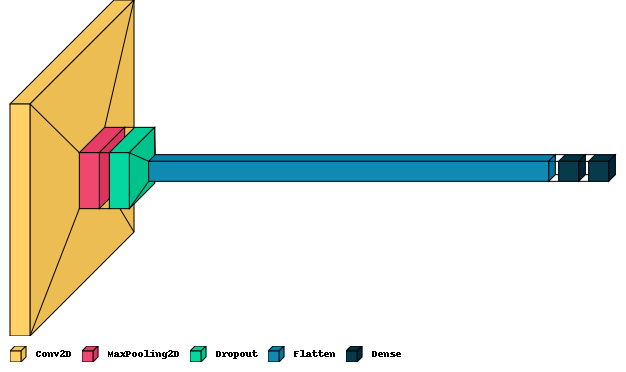

In [58]:
# Visualize model
visualkeras.layered_view(cnn_model, legend=True)

In [35]:
#! pip install pydot

In [59]:
plot_model(cnn_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Transfer Learning: EfficientNetB1

In [48]:
# Load in base model
base_model = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(80, 60, 3))
print(len(base_model.layers))

27018416/27018416 [==============================] - 0s 0us/step
340


In [49]:
# freeze certain layers
for layer in base_model.layers[:330]: # B7:810
    layer.trainable = False

In [52]:
#Adding custom Layers 
x = base_model.output
x = Flatten()(x)
#x = Dense(128, activation="relu")(x)
predictions = Dense(num_classes, activation="softmax")(x)

# creating and compile the final model 
final_model = Model(base_model.input, predictions)
final_model.compile(loss = "sparse_categorical_crossentropy", optimizer = Adam(lr=0.01), metrics=["accuracy"])
history = final_model.fit(x_train, y_train_encoded, 
                    batch_size=20, epochs=200,verbose=1,
                    validation_split = 0.2)

Epoch 1/200
77/77 [==============================] - 17s 122ms/step - loss: 4.6061 - accuracy: 0.1716 - val_loss: 7.5060 - val_accuracy: 0.1990
Epoch 2/200
77/77 [==============================] - 8s 99ms/step - loss: 2.7253 - accuracy: 0.1696 - val_loss: 3.1153 - val_accuracy: 0.2408
Epoch 3/200
77/77 [==============================] - 8s 99ms/step - loss: 2.4779 - accuracy: 0.1729 - val_loss: 1.9415 - val_accuracy: 0.1963
Epoch 4/200
77/77 [==============================] - 8s 99ms/step - loss: 2.3514 - accuracy: 0.1729 - val_loss: 2.0655 - val_accuracy: 0.1859
Epoch 5/200
77/77 [==============================] - 8s 99ms/step - loss: 2.2360 - accuracy: 0.1997 - val_loss: 1.9001 - val_accuracy: 0.2016
Epoch 6/200
77/77 [==============================] - 8s 99ms/step - loss: 2.9974 - accuracy: 0.1775 - val_loss: 2.6799 - val_accuracy: 0.2565
Epoch 7/200
77/77 [==============================] - 8s 99ms/step - loss: 2.6448 - accuracy: 0.2102 - val_loss: 2.3299 - val_accuracy: 0.1885
Epoc

Text(0.5, 1.0, 'Train - Accuracy')

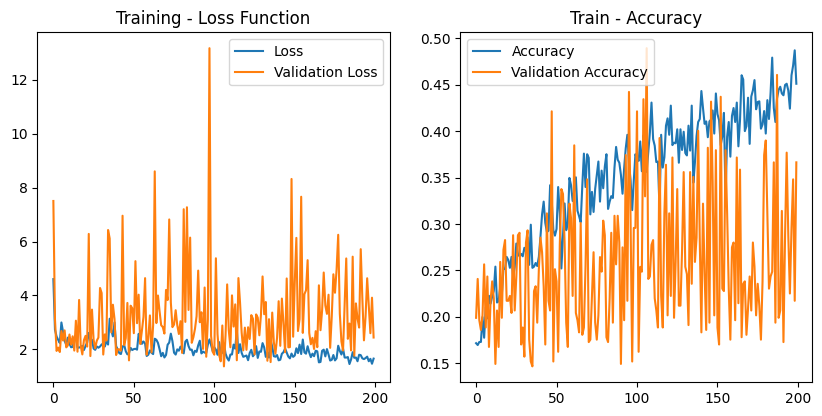

In [53]:
# Plot the training history
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')

In [54]:
# Transfer model performance
score = final_model.evaluate(x_test,y_test_encoded,verbose=0)
print('Test Loss : {:.4f}'.format(score[0]))
print('Test Accuracy : {:.4f}'.format(score[1]))

y_pred = final_model.predict(x_test)
y_pred_indices = np.argmax(y_pred, axis=1)
print("Classification Report:", metrics.classification_report(y_test_encoded, y_pred_indices))
print("Confusion Matrix:", metrics.confusion_matrix(y_test_encoded, y_pred_indices))

Test Loss : 2.6141
Test Accuracy : 0.3556
15/15 [==============================] - 3s 93ms/step
Classification Report:               precision    recall  f1-score   support

           0       0.74      0.61      0.67        79
           1       0.24      0.97      0.39        80
           2       0.75      0.04      0.07        79
           3       0.00      0.00      0.00        80
           4       0.48      0.50      0.49        80
           5       0.20      0.01      0.02        80

    accuracy                           0.36       478
   macro avg       0.40      0.36      0.27       478
weighted avg       0.40      0.36      0.27       478

Confusion Matrix: [[48 23  0  0  8  0]
 [ 0 78  0  0  2  0]
 [ 0 42  3  0 30  4]
 [15 61  1  0  3  0]
 [ 2 38  0  0 40  0]
 [ 0 78  0  0  1  1]]
